<a href="https://colab.research.google.com/github/fabduerr/AIWaterMeter/blob/main/nb/watermeter_clean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training CNN

v0.4: new training data, also adding test data and raw images, modifying read_img() function with 'augmentation-switch', automatic labeling by first 3 characters of image file

In [1]:
import cv2
import numpy as np
import matplotlib
import matplotlib.pylab as plt
import os
import re
from scipy.stats import rankdata

In [2]:
#!rm -rf AIWaterMeter
#!rm -rf raw
#!rm -rf <folder_name>
#!rm -rf <folder_name>

In [3]:
# getting image files 
!git clone https://github.com/fabduerr/AIWaterMeter.git
!unzip ./AIWaterMeter/rsc/raw_images.zip -d raw
!unzip ./AIWaterMeter/rsc/testdata.zip -d testdata
!unzip ./AIWaterMeter/rsc/trainingdata.zip -d trainingdata

Cloning into 'AIWaterMeter'...
remote: Enumerating objects: 87, done.
remote: Counting objects: 100% (87/87), done.
remote: Compressing objects: 100% (84/84), done.
remote: Total 87 (delta 38), reused 8 (delta 3), pack-reused 0
Unpacking objects: 100% (87/87), done.
Archive:  ./AIWaterMeter/rsc/raw_images.zip
  inflating: raw/2020-07-07-22_23_27.jpg  
  inflating: raw/2020-07-07-22_36_02.jpg  
  inflating: raw/2020-07-07-22_42_17.jpg  
  inflating: raw/2020-07-08-07_34_48.jpg  
  inflating: raw/2020-07-08-07_41_05.jpg  
  inflating: raw/2020-07-08-19_03_38.jpg  
  inflating: raw/2020-07-08-19_28_39.jpg  
  inflating: raw/2020-07-08-19_53_41.jpg  
  inflating: raw/2020-07-08-20_18_40.jpg  
  inflating: raw/2020-07-08-20_31_11.jpg  
  inflating: raw/2020-07-08-20_37_26.jpg  
  inflating: raw/2020-07-08-20_43_41.jpg  
  inflating: raw/2020-07-08-20_49_56.jpg  
  inflating: raw/2020-07-08-20_56_11.jpg  
  inflating: raw/2020-07-08-21_08_42.jpg  
  inflating: raw/2020-07-08-21_27_27.jpg  
 

# Create Median Image (can be skipped, data is already available: 'med1.jpg')

In [2]:
# fix image rotation by 15.3
def rotate_image(image, angle):
  image_center = tuple(np.array(image.shape[1::-1]) / 2)
  rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
  result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
  return result

def load_imgs(path, file):
    if file [-4:] == ".jpg":
        image = cv2.imread(os.path.join(path,file), cv2.IMREAD_GRAYSCALE)
        image = rotate_image(image, 15.3)
        return image  

In [3]:
# load all images into a list
path = os.path.join('raw')
imgs = [load_imgs(path = path, file = file) for file in os.listdir(path)]

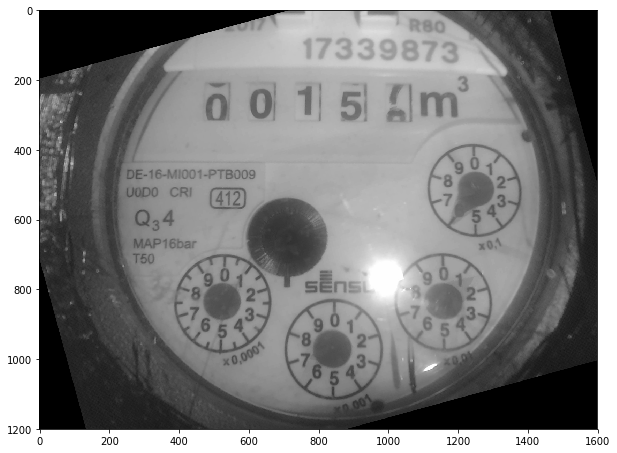

In [4]:
medi = np.median(imgs, axis = 0)
#maxi = np.max(imgs, axis = 0)
#mini = np.min(imgs, axis = 0)
plt.figure(figsize=(10,10))
plt.imshow(medi, cmap='gray', vmin=0, vmax=255)
#cv2.imwrite("water_medi.jpg", medi)
#cv2.imwrite("water_maxi.jpg", maxi)


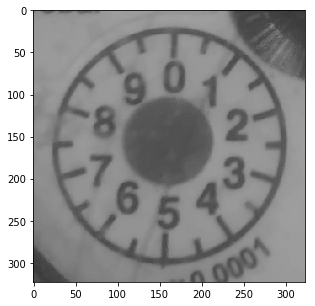

In [5]:
#cropping the outer left dial
d = 20
r = 283
med = medi[699-d:699+r+d, 385-d:385+r+d]
plt.figure(figsize=(5,5))
plt.imshow(med, cmap='gray', vmin=0, vmax=255)

## Create training data

> Training data is made with point image and median image

Note: can be skipped, data is already available: 'testimages.zip'

In [6]:
med_img = cv2.imread('AIWaterMeter/rsc/med1.jpg',cv2.IMREAD_GRAYSCALE)
# pointer created with GIMP
meter = cv2.imread('AIWaterMeter/rsc/pointer0.jpg',cv2.IMREAD_GRAYSCALE)

y = meter.shape[0]
x = meter.shape[1]
meter_center = (y/2, x/2)

for alpha in range(0,3600, 180):
    # val holds the label information. it will be stored within the file name later
    val = str(alpha/360.)
    val = re.sub(r'[.]', 'p', val)
    #small correction 
    alpha = alpha - 10
    # each label will have 5 images with some small rotation offset 
    for a in range(-2,3,1):
        beta = alpha + a*10 # 10 degrees 
        M = cv2.getRotationMatrix2D(meter_center, -beta/10, 1)
        meter_rot = cv2.warpAffine(meter, M, (y, x), flags=cv2.INTER_LINEAR, borderValue=(255,255,255))

        #create an 'empty' image 
        blank = np.zeros((y,x))
        #replace pixel in the image with pixels from median image or pointer image
        for i in range(y):
            for j in range(x):
                if meter_rot[i,j] < 150:
                    blank[i,j] = min(meter_rot[i,j],med_img[i,j])
                else:
                    blank[i,j] = med_img[i,j]
        #blank = cv2.resize(blank, (200, 200), interpolation = cv2.INTER_AREA)
        #save all the training images
        filepath = os.path.join('watermeter','testimages',val+str(a)+".jpg")
        cv2.imwrite(filepath,blank)


# The fun part starts here...

In [7]:
# function for immediate data augmentation during image load and image resizing
def initial_augmentation(img, res_x, res_y):
    # add some minor random zoom and aspect ration adjustment
    row = img.shape[0]
    col = img.shape[1]
    col_start = np.random.randint(0,col//20)
    row_start = np.random.randint(0,row//20)
    col_end = col - np.random.randint(0,col//20)
    row_end = row - np.random.randint(0,row//20)
    img = img[col_start:col_end, row_start:row_end]
    img = cv2.resize(img, (res_y, res_x), interpolation = cv2.INTER_AREA)
    # adjust brightness and contrast
    alpha = np.random.randint(low=85, high=115)/100
    beta = np.random.randint(low=-20, high=+20)
    img = np.clip(alpha*img + beta, 0 , 255)
    return(img)

In [8]:
# function to read in training images from a folder multiple times with random augmentation. 
# It assumes that the images are sorted in the folder. For every image there is also a label created [0,1, .. , amount of images].
# Function returns image list and label list
def read_img(path, augmentation = True, times = 10):
    img_files = os.listdir(path)
    img_files = sorted(img_files)
    images = []
    typeX = []
    for file in img_files:
        # load image
        if file[-3:] == 'jpg':
            img = cv2.imread(os.path.join(path,file), cv2.IMREAD_GRAYSCALE)
            if augmentation:
                for i in range(times):
                    img = initial_augmentation(img, 200, 200)
                    images.append(img)
                    typeX.append(file[:3])
            else:
                images.append(img)
                typeX.append(file[:3])
    return (images, typeX)  

# Create train data and labels

In [9]:
# read train data and train labels. Each image is added 5 times with augmentation
trainX, trainY = read_img(path = 'trainingdata',augmentation = True, times = 5)
# total images in train data: 20 classes, 5 images per class, each image used 5 times: 20 *5 * 5 = 500
print(len(trainX))
# convert strings in trainY to integers
trainY = rankdata(trainY, method = 'dense')-1

1240


6.5


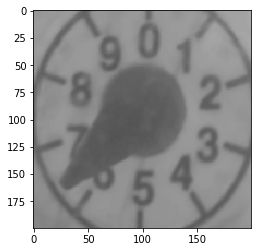

In [10]:
# show a random image and the label
b = np.random.randint(0,len(trainX))
print(trainY[b]*0.5)
plt.imshow(trainX[b], cmap='gray', vmin=0, vmax=255)

In [11]:
# keras needs np.array as input with shape (image count, rex y, res x, number of channels). Here (500,200,200,1)
trainX = np.asarray(trainX)
trainX = trainX.reshape(len(trainX),200,200,1)
trainY = np.asarray(trainY)

In [12]:
# trainY needs one-hot-encoding
from keras.utils import to_categorical
trainY = to_categorical(trainY)

Using TensorFlow backend.


In [13]:
# shuffle the train data set
from sklearn.utils import shuffle
trainX, trainY = shuffle(trainX, trainY)

# Now build the model...

In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import models
from tensorflow.python.framework import ops
from tensorflow.keras.callbacks import ReduceLROnPlateau
ops.reset_default_graph()

In [31]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation="relu", padding = 'same', input_shape= (200,200,1)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, kernel_size=(3, 3), activation="relu", padding = 'same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, kernel_size=(3, 3), activation="relu", padding = 'same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, kernel_size=(3, 3), activation="relu", padding = 'same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(512, activation="relu"))

model.add(Dense(256, activation="relu"))

model.add(Dense(20, activation="softmax"))

model.compile(optimizer=Adam(lr=0.001), loss="categorical_crossentropy", metrics=["accuracy"])

# Image Data Generator for data augmentation

In [32]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

reduce_lr = ReduceLROnPlateau(
    monitor="loss",
    factor=0.3,
    patience=6,
    verbose=1,
    mode="auto",
    min_delta=0.001,
    cooldown=1,
    min_lr=0.000001,
    )

early_stop = EarlyStopping(
    monitor="val_loss", 
    min_delta=0.0005, 
    patience=20, mode="auto")


gen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=10,
    fill_mode="constant",
    cval = 0.5,  
    )

In [35]:
# Split into test (85%) and validation data (15%). 
z = int(len(trainX)*0.15)
X_train =  trainX[:-z]
y_train = trainY[:-z]
X_val = trainX[-z:]
y_val = trainY[-z:]

### Actual training
total time ~50x 18s = 900s =15mn

In [37]:
# Note: Validation data will not get additional augmentation by data generator. 
# Thus, validation accuracy will most likely exceed test accuracy during training.
# Input is normalized by 255 (max possible pixel value) to improve learning. Later on test images (predictions) also need to be normalized
history = model.fit_generator(
    gen.flow(
    x = X_train/255.,
    y = y_train,  
    batch_size=32, 
    shuffle=True,
    ), 
    steps_per_epoch=len(X_train) / 32, 
    epochs=50,
    #callbacks=[reduce_lr, early_stop],
    validation_data = (X_val/255., y_val),                          
    )

/home/omega/.local/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
32/32 [==============================] - 19s 304ms/step - loss: 3.0004 - accuracy: 0.0417 - val_loss: 2.9982 - val_accuracy: 0.0376
Epoch 2/50
32/32 [==============================] - 2s 74ms/step - loss: 2.9939 - accuracy: 0.0511 - val_loss: 2.9987 - val_accuracy: 0.0591
Epoch 3/50
32/32 [==============================] - 2s 73ms/step - loss: 2.9907 - accuracy: 0.0861 - val_loss: 3.0070 - val_accuracy: 0.0484
Epoch 4/50
32/32 [==============================] - 2s 73ms/step - loss: 2.9298 - accuracy: 0.1073 - val_loss: 2.7661 - val_accuracy: 0.3387
Epoch 5/50
32/32 [==============================] - 2s 74ms/step - loss: 2.4166 - accuracy: 0.2891 - val_loss: 1.0399 - val_accuracy: 0.6290
Epoch 6/50
32/32 [==============================] - 2s 73ms/step - loss: 1.4237 - accuracy: 0.4500 - val_loss: 0.6685 - val_accuracy: 0.7742
Epoch 7/50
32/32 [==============================] - 2s 73ms/step - loss: 1.0356 - accuracy: 0.6006 - val_loss: 0.5384 - val_accuracy: 0.8226
Epoch 8/50


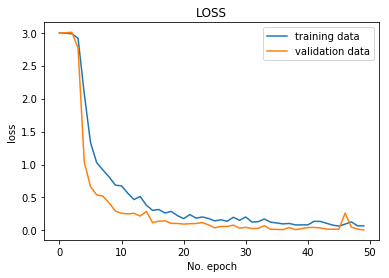

In [38]:
plt.plot(history.history['loss'], label='training data')
plt.plot(history.history['val_loss'], label='validation data')
plt.title('LOSS')
plt.ylabel('loss')
plt.xlabel('No. epoch')
plt.legend(loc="upper right")
plt.show()

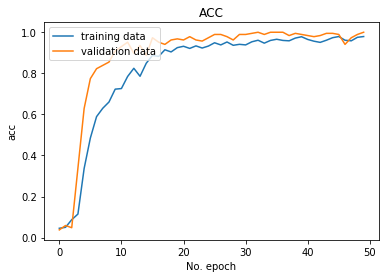

In [39]:
#was : plt.plot(history.history['acc'], label='training data')
plt.plot(history.history['accuracy'], label='training data')
#was: plt.plot(history.history['val_acc'], label='validation data')
plt.plot(history.history['val_accuracy'], label='validation data')
plt.title('ACC')
plt.ylabel('acc')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [40]:
model.save('watermeter.h5')

In [41]:
predictions = model.predict(trainX/255.)

In [42]:
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix, classification_report
expected = np.argmax(trainY[:], axis = 1)
predicted = np.argmax(predictions[:], axis = 1)
print(classification_report(expected, predicted))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       1.00      1.00      1.00        60
           2       1.00      1.00      1.00        60
           3       1.00      1.00      1.00        60
           4       1.00      1.00      1.00        70
           5       1.00      1.00      1.00        70
           6       1.00      1.00      1.00        70
           7       1.00      1.00      1.00        60
           8       1.00      1.00      1.00        70
           9       1.00      1.00      1.00        60
          10       1.00      1.00      1.00        60
          11       1.00      1.00      1.00        60
          12       1.00      1.00      1.00        60
          13       1.00      1.00      1.00        60
          14       1.00      1.00      1.00        60
          15       1.00      1.00      1.00        60
          16       1.00      1.00      1.00        70
          17       1.00    

In [43]:
print(confusion_matrix(expected, predicted))

[[60  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 60  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 60  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 60  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 70  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 70  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 70  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 60  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 70  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 60  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 60  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 60  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 60  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0 60  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 60  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 60  0  0

# Simulate a random position and evaluate it with the model

In [44]:
alpha = 330
alpha = 10*alpha

meter = cv2.imread('/content/AIWaterMeter/rsc/pointer0.jpg',cv2.IMREAD_GRAYSCALE)

y = meter.shape[0]
x = meter.shape[1]
meter_center = (y/2, x/2)

med_img = cv2.imread('/content/AIWaterMeter/rsc/med1.jpg',cv2.IMREAD_GRAYSCALE)

#small correction 
beta = alpha - 10
M = cv2.getRotationMatrix2D(meter_center, -beta/10, 1)
meter_rot = cv2.warpAffine(meter, M, (y, x), flags=cv2.INTER_LINEAR, borderValue=(255,255,255))

test_img = np.zeros((y,x))

for i in range(y):
    for j in range(x):
        if meter_rot[i,j] < 150:
            test_img[i,j] = min(meter_rot[i,j],med_img[i,j])
        else:
            test_img[i,j] = med_img[i,j]
test_img = cv2.resize(test_img, (200, 200), interpolation = cv2.INTER_AREA)
plt.imshow(test_img, cmap='gray', vmin=0, vmax=255)



AttributeError: 'NoneType' object has no attribute 'shape'

In [45]:
# get test image in correct shape 
test_img = np.reshape(test_img,(1,200,200,1))
# prediction: test image label
np.argmax(model.predict(test_img/255.))*0.5

NameError: name 'test_img' is not defined

In [45]:
# prediction probablities
model.predict(test_img/255.)

array([[3.9481180e-05, 4.7576958e-03, 7.9801738e-02, 1.5713938e-03,
        5.1518192e-04, 1.8492964e-06, 6.6550541e-07, 2.2813143e-10,
        1.5276735e-08, 6.1362254e-10, 6.8625639e-07, 5.9743429e-04,
        6.5284863e-02, 1.7501316e-03, 1.0061289e-06, 3.0139654e-07,
        4.4677792e-05, 5.8215898e-03, 8.2993263e-01, 9.8786345e-03]],
      dtype=float32)

# Predict a user image

In [46]:
model = models.load_model("watermeter.h5")

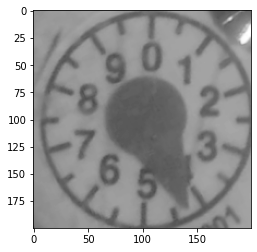

In [46]:
img = cv2.imread('testdata/4p5-1.jpg', cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, (200, 200), interpolation = cv2.INTER_AREA)
plt.imshow(img,cmap='gray', vmin=0, vmax=255)

In [47]:
img = np.reshape(img,(1,200,200,1))/255.
result = model.predict(img)

In [48]:
print("Classified as: " + str(np.argmax(result)*0.5))
result

Classified as: 4.0


array([[6.05326178e-10, 2.13020157e-11, 1.93345936e-13, 1.32406155e-17,
        4.92704259e-14, 1.69292260e-13, 3.45975609e-11, 1.30626256e-08,
        9.14234698e-01, 8.57651085e-02, 7.03233782e-09, 5.50686823e-11,
        7.11066692e-11, 2.58597310e-12, 7.97615186e-12, 1.00920650e-09,
        1.51052618e-07, 2.06773105e-08, 1.38933786e-11, 1.39374193e-10]],
      dtype=float32)